## 1. Project Setup and Imports
This initial block sets up the project by importing all the necessary libraries. It includes TensorFlow and Keras for building the neural network, NumPy for numerical operations, and Matplotlib for visualizing the results. We also set a universal random seed to ensure that our experimental results are reproducible.

In [2]:
# Import NumPy for efficient numerical operations, especially with arrays.
import numpy as np

# Import TensorFlow, the core deep learning framework.
import tensorflow as tf

# From Keras (part of TensorFlow), import the main Model class.
from tensorflow.keras.models import Model

# Import the specific layers we will use to build our neural network.
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Bidirectional

# Import a helper function to make all signature sequences the same length.
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import Matplotlib for plotting graphs and visualizing signatures.
import matplotlib.pyplot as plt

# Set a random seed for both NumPy and TensorFlow.
# This ensures that any process involving randomness (like initializing model weights)
# will be the same every time the code runs, making our results reproducible.
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Generation and Preparation
Since real signature data is sensitive and not publicly available, we begin by creating a realistic synthetic dataset. This process involves two key steps:

**Signature Generation:** We programmatically generate individual signatures, each defined by four key features: the X and Y coordinates of the pen, the pressure applied, and the time elapsed between points (speed). Each "user" is assigned a unique base style to ensure their signatures are distinct.

**Dataset Assembly:** We then create pairs of these signatures. A "genuine" pair consists of two different signatures from the same user, while a "forged" pair consists of two signatures from different users. Finally, this data is preprocessed and split into training and validation sets,

In [3]:
def generate_synthetic_signature(base_style, noise_level=0.05, length=100):
    """Generates a single signature sequence based on a 'base_style' dictionary."""

    # Create a time vector 't' which will be the input for our mathematical functions.
    t = np.linspace(0, 2 * np.pi, length)

    # Generate the base coordinates using Lissajous curves.
    # This creates complex, looping shapes that resemble a signature's path.
    x = np.sin(base_style['a'] * t + base_style['delta'])
    y = np.sin(base_style['b'] * t)

    # Simulate the signature's dynamics: pressure and speed (time delta).
    pressure = np.abs(np.sin(base_style['p_freq'] * t))  # Pressure varies over the stroke.
    dt = np.full(length, base_style['speed']) + np.random.normal(0, 0.005, length) # Speed has a base value plus some variation.

    # Add random noise ('jitter') to each feature to simulate natural human variation.
    # This ensures that even signatures with the same base_style are not identical.
    x += np.random.normal(0, noise_level, length)
    y += np.random.normal(0, noise_level, length)
    pressure += np.random.normal(0, noise_level / 2, length)

    # Ensure the pressure values stay within a realistic range of 0 to 1.
    pressure = np.clip(pressure, 0, 1)

    # Combine the four features (x, y, pressure, dt) into a single array.
    # The final shape will be (length, 4), representing the sequence of points.
    signature = np.vstack([x, y, pressure, dt]).T
    return signature

def create_signature_dataset(num_users=10, samples_per_user=20, max_len=150):
    """Creates a full dataset of genuine-genuine and genuine-forged signature pairs."""

    # This list will store all generated signatures with their corresponding user ID.
    user_signatures = []

    # Create a unique "base style" for each user. This defines their fundamental signing style.
    base_styles = [
        {'a': np.random.randint(1, 4), 'b': np.random.randint(1, 4), 'delta': np.pi / np.random.randint(1, 4), 'p_freq': np.random.uniform(1, 3), 'speed': np.random.uniform(0.01, 0.05)}
        for _ in range(num_users)
    ]

    # Generate multiple signature samples for each user.
    for i in range(num_users):
        for _ in range(samples_per_user):
            # Each signature is stored as a tuple: (user_id, signature_data).
            user_signatures.append((i, generate_synthetic_signature(base_styles[i], length=np.random.randint(100, 150))))

    # These lists will hold the final pairs of signatures and their labels.
    pairs = []
    labels = []

    # Iterate through all generated signatures to create pairs for training.
    for i in range(len(user_signatures) - 1):
        user_id_1, sig_1 = user_signatures[i]

        # --- Create a genuine-genuine pair ---
        # Find another signature from the same user.
        same_user_indices = [idx for idx, (uid, _) in enumerate(user_signatures) if uid == user_id_1 and idx != i]
        if same_user_indices:
            idx_2 = np.random.choice(same_user_indices)
            _, sig_2_genuine = user_signatures[idx_2]
            pairs.append([sig_1, sig_2_genuine])
            labels.append(1) # Label 1 indicates a genuine pair.

        # --- Create a genuine-forged pair ---
        # Find a signature from a different user.
        diff_user_indices = [idx for idx, (uid, _) in enumerate(user_signatures) if uid != user_id_1]
        if diff_user_indices:
            idx_3 = np.random.choice(diff_user_indices)
            _, sig_3_forged = user_signatures[idx_3]
            pairs.append([sig_1, sig_3_forged])
            labels.append(0) # Label 0 indicates a forged pair.

    # Pad all signature sequences to the same length ('max_len').
    # This is a necessary step for batch processing in a neural network.
    padded_pairs = []
    for sig1, sig2 in pairs:
        # 'pad_sequences' adds zeros to the end of shorter sequences.
        padded_sig1 = pad_sequences([sig1], maxlen=max_len, dtype='float32', padding='post')[0]
        padded_sig2 = pad_sequences([sig2], maxlen=max_len, dtype='float32', padding='post')[0]
        padded_pairs.append([padded_sig1, padded_sig2])

    # Return the final dataset as NumPy arrays.
    return np.array(padded_pairs), np.array(labels)

# --- Generate the data ---
# Define the parameters for our dataset.
MAX_LEN = 150     # Each signature sequence will be 150 points long.
FEATURES = 4      # Each point has 4 features: x, y, pressure, dt.

# Call the function to create the full dataset of pairs and labels.
pairs, labels = create_signature_dataset(num_users=20, samples_per_user=10, max_len=MAX_LEN)

# Split the data into a training set (80%) and a validation set (20%).
# The model learns from the training set and is evaluated on the validation set.
split_ratio = 0.8
split_index = int(len(pairs) * split_ratio)

X_train = pairs[:split_index]
y_train = labels[:split_index]
X_val = pairs[split_index:]
y_val = labels[split_index:]

# Separate the pairs into two distinct inputs for our Siamese network.
# X_train_1 will hold the first signature of each pair, X_train_2 the second.
X_train_1 = X_train[:, 0]
X_train_2 = X_train[:, 1]
X_val_1 = X_val[:, 0]
X_val_2 = X_val[:, 1]

# Print the final shapes of the data arrays to verify everything is correct.
print(f"Training data shape: {X_train_1.shape}")
print(f"Validation data shape: {X_val_1.shape}")

Training data shape: (318, 150, 4)
Validation data shape: (80, 150, 4)


## 3. Model Architecture 🧠
This section defines the architecture of our signature verification model using a Siamese network. This special type of neural network is designed to compare two inputs and determine their similarity.

Our implementation has two key components:

**The Base Network:** A core model built with Bidirectional LSTM layers that processes a single signature sequence. Its job is to read the dynamic properties of a signature and convert it into a compact numerical representation, known as an embedding or "fingerprint."

**The Siamese Structure:** The base network is used twice with shared weights to process both signatures in a pair. This ensures both signatures are analyzed using the exact same criteria. The final output of the model is the Euclidean distance between the two embeddings. A small distance suggests the signatures are from the same person, while a large distance suggests a forgery.

In [4]:
def create_base_network(input_shape):
    """Creates the core network that processes one signature sequence and outputs its embedding."""

    # Define the input layer with the shape of a single signature.
    input = Input(shape=input_shape)

    # The first Bidirectional LSTM layer. It processes the sequence forwards and backwards.
    # 'return_sequences=True' is crucial because we need to pass the full output sequence to the next LSTM layer.
    lstm1 = Bidirectional(LSTM(64, return_sequences=True))(input)

    # The second Bidirectional LSTM layer. It does not return sequences,
    # so it outputs only the final hidden state, effectively summarizing the entire sequence.
    lstm2 = Bidirectional(LSTM(32))(lstm1)

    # A standard Dense (fully-connected) layer to transform the LSTM output
    # into a final, fixed-size feature vector called an "embedding".
    output = Dense(32, activation='relu')(lstm2)

    # Create and return the base network model.
    return Model(input, output)

# Define the shape for a single input signature (e.g., 150 time steps, 4 features).
input_shape = (MAX_LEN, FEATURES)

# Create an instance of our base network.
base_network = create_base_network(input_shape)

# Define two separate input layers for the Siamese network, one for each signature in a pair.
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# This is the core of the Siamese architecture: the *same* base_network (with shared weights)
# is used to process both inputs. This forces the model to learn a consistent way
# of mapping signatures into the embedding space.
processed_a = base_network(input_a)
processed_b = base_network(input_b)

def euclidean_distance(vectors):
    """
    Calculates the Euclidean distance between the two output embedding vectors.
    The formula is sqrt(sum((x - y)^2)).
    """
    # Unpack the two vectors from the input list.
    x, y = vectors
    # Calculate the sum of squared differences.
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    # Return the square root of the sum, adding a small epsilon for numerical stability.
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

# A Lambda layer wraps our custom Python function so it can be used as a layer in the Keras model.
# It takes the two processed embeddings and outputs their calculated distance.
distance = Lambda(euclidean_distance)([processed_a, processed_b])

# The final Siamese model is defined with two inputs and one output (the distance).
siamese_model = Model([input_a, input_b], distance)

# Print a summary of the complete Siamese network architecture.
print("Siamese Model Summary:")
siamese_model.summary()

Siamese Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 150, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 32)        │     78,624 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,624 (307.12 KB)

 Trainable params: 78,624 (307.12 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Loss Function and Model Compilation
This section defines the contrastive loss function, which is essential for training a Siamese network. Unlike standard loss functions that predict a class, this one's goal is to learn a distance metric. It works by teaching the model to:

Minimize the distance between signatures from the same person (genuine pairs).

Maximize the distance between signatures from different people (forged pairs).

Finally, the model is compiled with this custom loss function and the Adam optimizer, preparing it for the training phase.

In [5]:
# The contrastive loss function is designed to train a Siamese network.
# Its goal is to create a small distance between embeddings of similar items (genuine pairs)
# and a large distance between embeddings of dissimilar items (forged pairs).
# The formula is: L = y * d^2 + (1-y) * max(0, margin - d)^2
# where 'd' is the predicted distance and 'y' is the true label.

def contrastive_loss(y_true, y_pred):
    """
    Custom contrastive loss function.

    Args:
        y_true: The ground truth label (1 for genuine, 0 for forged).
        y_pred: The predicted distance from the model.
    """
    # Ensure the label's data type matches the prediction's for calculations.
    y_true = tf.cast(y_true, y_pred.dtype)

    # 'margin' is a hyperparameter that defines a radius. Forged pairs are only penalized
    # if their distance is *within* this radius.
    margin = 1.0

    # This is the loss component for a genuine pair (when y_true is 1).
    # The loss is the squared distance, which we want to minimize (push towards 0).
    square_pred = tf.square(y_pred)

    # This is the loss component for a forged pair (when y_true is 0).
    # We only apply a penalty if the distance is less than the margin.
    # The goal is to maximize this distance, pushing it to be at least as large as the margin.
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))

    # Combine the two loss components. If y_true is 1, the second part becomes zero.
    # If y_true is 0, the first part becomes zero.
    # 'tf.reduce_mean' calculates the average loss over the entire batch.
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# Compile the model to configure it for training.
siamese_model.compile(
    loss=contrastive_loss,  # Specify our custom loss function.
    optimizer='adam'         # Use the Adam optimizer, a standard and effective choice.
)

## 5. Model Training 🚂
This block contains the final step: training the model. Using the .fit() method, we pass the prepared training and validation data to the Siamese network. The model will then iterate through the dataset for a set number of epochs, learning to minimize the contrastive loss. At the end of this process, the model's weights will be optimized to effectively distinguish between genuine and forged signatures.

In [6]:
# A simple print statement to indicate that the training is about to begin.
print("\n--- Starting Model Training ---")

# The 'fit' method starts the training process.
# The returned 'history' object will store the training progress (like loss) after each epoch.
history = siamese_model.fit(
    # The training data: a list of two inputs (for the two signatures in a pair) and their corresponding labels.
    [X_train_1, X_train_2], y_train,

    # The validation data, used to evaluate the model's performance on unseen data after each epoch.
    validation_data=([X_val_1, X_val_2], y_val),

    # The number of signature pairs to process at once before updating the model's weights.
    batch_size=64,

    # The total number of times the model will iterate over the entire training dataset.
    epochs=20
)

# A print statement to indicate that the training process has been completed.
print("--- Training Finished ---\n")


--- Starting Model Training ---
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - loss: 0.3287 - val_loss: 0.1660
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1546 - val_loss: 0.1431
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1145 - val_loss: 0.1224
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1027 - val_loss: 0.1413
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0911 - val_loss: 0.1381
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0794 - val_loss: 0.1216
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0698 - val_loss: 0.1097
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0626 - val_loss: 0.0899
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0566 - val_loss: 0.0763
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0524 - val_loss: 0.0696
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0452 - val_loss: 0.0620
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step -

## 6. Prediction and Evaluation 📊
With the model now trained, this final section evaluates its performance on the unseen validation data. First, the .predict() method is used to get a similarity distance for every pair. A decision threshold is then established to convert this continuous distance score into a final verdict: "Genuine" or "Forged."

To demonstrate the model's effectiveness, we select one genuine pair and one forged pair, print the model's prediction, and visualize the signatures side-by-side for a clear, qualitative assessment of the results.

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
--- Testing a Genuine Pair ---
Predicted Distance: 0.1174
Prediction: Genuine (Correct: Genuine)


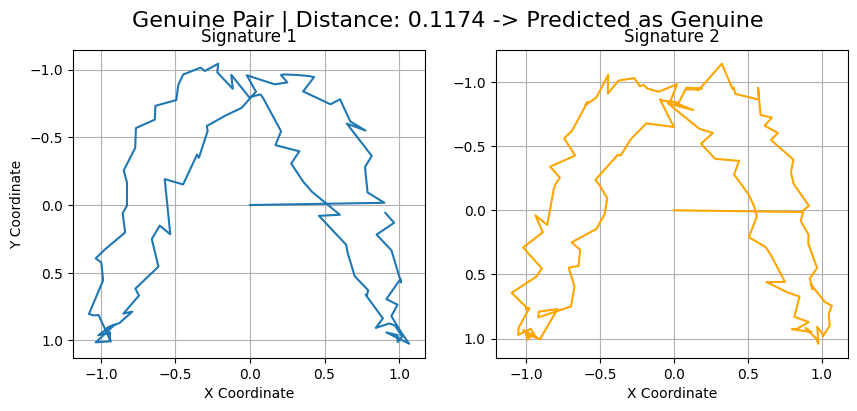


--- Testing a Forged Pair ---
Predicted Distance: 4.5049
Prediction: Forged (Correct: Forged)


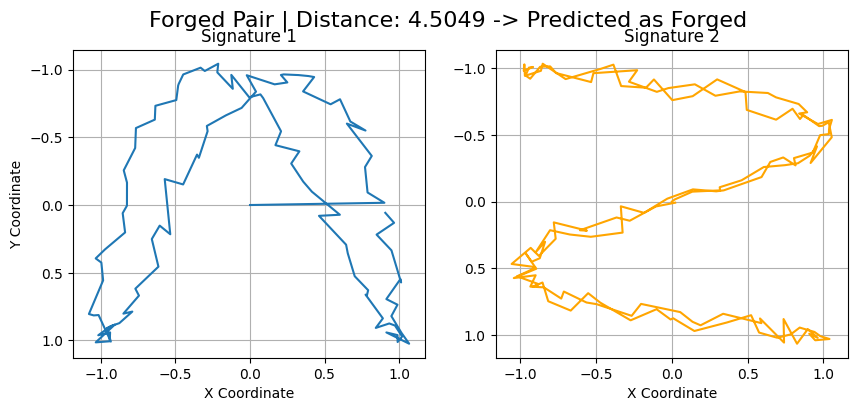

In [7]:
def plot_signatures(sig1, sig2, title):
    """A helper function to visualize a pair of signatures side-by-side."""

    # Create a new figure to draw the plots on.
    plt.figure(figsize=(10, 4))

    # --- Plot Signature 1 ---
    # Create a subplot grid with 1 row and 2 columns, and select the first plot.
    plt.subplot(1, 2, 1)
    # Plot the x-coordinates (column 0) against the y-coordinates (column 1).
    plt.plot(sig1[:, 0], sig1[:, 1], label='Signature 1')
    # Invert the y-axis so the signature appears upright, similar to how we write on paper.
    plt.gca().invert_yaxis()
    # Add titles and labels for clarity.
    plt.title("Signature 1")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)

    # --- Plot Signature 2 ---
    # Select the second plot in our grid.
    plt.subplot(1, 2, 2)
    plt.plot(sig2[:, 0], sig2[:, 1], label='Signature 2', color='orange')
    plt.gca().invert_yaxis()
    plt.title("Signature 2")
    plt.xlabel("X Coordinate")
    plt.grid(True)

    # Add a main title to the entire figure.
    plt.suptitle(title, fontsize=16)
    # Display the completed plot.
    plt.show()

# --- Make predictions on the entire validation set ---
# The '.predict()' method runs the data through the trained model.
# The output 'predictions' will be an array of distance scores for each pair.
predictions = siamese_model.predict([X_val_1, X_val_2])

# --- Define a decision threshold ---
# This value is our cutoff point. If the model's output distance for a pair
# is below this threshold, we classify it as Genuine. Otherwise, it's Forged.
THRESHOLD = 0.25

# --- ✅ Test with a genuine pair from the validation set ---
# Find the index of the first pair in our validation set with a "genuine" label (1).
genuine_pair_index = np.where(y_val == 1)[0][0]
# Get the two signatures from that pair.
sig1_gen = X_val_1[genuine_pair_index]
sig2_gen = X_val_2[genuine_pair_index]
# Get the corresponding distance score that our model predicted.
distance_gen = predictions[genuine_pair_index][0]
# Apply the threshold to make a final classification.
result_gen = "Genuine" if distance_gen < THRESHOLD else "Forged"

# Print the results to the console.
print(f"--- Testing a Genuine Pair ---")
print(f"Predicted Distance: {distance_gen:.4f}")
print(f"Prediction: {result_gen} (Correct: Genuine)")

# Visualize the genuine pair and its result.
plot_signatures(sig1_gen, sig2_gen, f"Genuine Pair | Distance: {distance_gen:.4f} -> Predicted as {result_gen}")



# --- ❌ Test with a forged pair from the validation set ---
# Find the index of the first pair in our validation set with a "forged" label (0).
forged_pair_index = np.where(y_val == 0)[0][0]
# Get the two signatures and their predicted distance.
sig1_forged = X_val_1[forged_pair_index]
sig2_forged = X_val_2[forged_pair_index]
distance_forged = predictions[forged_pair_index][0]
# Apply the threshold to classify the pair.
result_forged = "Genuine" if distance_forged < THRESHOLD else "Forged"

# Print the results to the console.
print(f"\n--- Testing a Forged Pair ---")
print(f"Predicted Distance: {distance_forged:.4f}")
print(f"Prediction: {result_forged} (Correct: Forged)")

# Visualize the forged pair and its result.
plot_signatures(sig1_forged, sig2_forged, f"Forged Pair | Distance: {distance_forged:.4f} -> Predicted as {result_forged}")

## 7. Explainable AI: The Detailed Comparison Report 🧠
To understand why the model makes a certain decision, we move beyond a simple verdict and generate a detailed explainable AI (XAI) report. This final section uses a technique called Occlusion Analysis to probe the model and visualize its reasoning.

The function generates a comprehensive 3x2 report that provides a complete story for any signature comparison:

Occlusion Analysis Heatmaps: The top row visualizes the most critical parts of each signature's path. "Hot" colors (yellow/green) indicate the areas the model focused on most, revealing its "thought process."

Dynamic Feature Plots: The middle row directly compares the pressure and speed profiles of the two signatures over time, making it easy to spot unnatural hesitations or inconsistent pressure in a forgery.

Quantitative Summary: The bottom row presents the final verdict in a clear, color-coded format, alongside a table of key dynamic statistics for a quantitative comparison.

This provides a complete, easy-to-understand explanation for the model's final decision.

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# This assumes you have the following functions defined:
# - calculate_signature_stats()
# And your trained `base_network` and `siamese_model`, plus `MAX_LEN` and `THRESHOLD`.

def generate_final_enhanced_report(sig1, sig2, sig1_name, sig2_name, base_network, siamese_model, max_len, threshold):
    """
    Generates a final, enhanced report with a professional layout, dynamic plots, and clear indicators.
    """
    print(f"\n--- Generating Final Enhanced Report: {sig1_name} vs. {sig2_name} ---")

    # --- 1. Prediction and Statistics ---
    input_sig1_padded = pad_sequences([sig1], maxlen=max_len, dtype='float32', padding='post')
    input_sig2_padded = pad_sequences([sig2], maxlen=max_len, dtype='float32', padding='post')
    distance = siamese_model.predict([input_sig1_padded, input_sig2_padded], verbose=0)[0][0]
    verdict = "Genuine" if distance < threshold else "Forged"
    stats1 = calculate_signature_stats(sig1); stats2 = calculate_signature_stats(sig2)

    # --- 2. Create the Report Layout (3 rows, 2 columns) ---
    fig, axes = plt.subplots(3, 2, figsize=(15, 15), gridspec_kw={'height_ratios': [3, 2, 1.5]})
    fig.suptitle(f"Explainable AI Signature Report", fontsize=22, weight='bold')
    fig.tight_layout(pad=6.0)

    # --- 3. Occlusion Analysis Plots ---
    for ax, sig, name in [(axes[0, 0], sig1, sig1_name), (axes[0, 1], sig2, sig2_name)]:
        ax.set_title(f"Occlusion Analysis for {name}", fontsize=14)
        input_sig = pad_sequences([sig], maxlen=max_len, dtype='float32', padding='post')
        original_embedding = base_network.predict(input_sig, verbose=0)
        scores = np.zeros(len(sig))
        for i in range(len(sig) - 5 + 1):
            perturbed = input_sig.copy(); perturbed[0, i:i+5, :] = 0.0
            perturbed_embedding = base_network.predict(perturbed, verbose=0)
            scores[i:i+5] += np.linalg.norm(original_embedding - perturbed_embedding)
        if np.max(scores) > 0: scores /= np.max(scores)

        points = sig[:, :2].reshape(-1, 1, 2); segments = np.concatenate([points[:-1], points[1:]], axis=1)
        cmap = cm.get_cmap('viridis'); norm = mcolors.Normalize(vmin=0, vmax=1.0)

        for i in range(len(segments)):
            avg_importance = (scores[i] + scores[i+1]) / 2
            ax.plot(segments[i][:, 0], segments[i][:, 1], color=cmap(avg_importance), linewidth=3.5)
        ax.grid(True); ax.set_xlabel("X Coordinate"); ax.set_ylabel("Y Coordinate")

    # --- 4. NEW: Dynamic Feature Plots ---
    # Pressure vs. Time
    ax_pressure = axes[1, 0]
    ax_pressure.plot(sig1[:, 2], label=sig1_name)
    ax_pressure.plot(sig2[:, 2], label=sig2_name, linestyle='--')
    ax_pressure.set_title("Pressure Profile Over Time", fontsize=14); ax_pressure.set_xlabel("Time Step"); ax_pressure.set_ylabel("Pressure")
    ax_pressure.legend(); ax_pressure.grid(True)

    # Speed (dt) vs. Time
    ax_speed = axes[1, 1]
    ax_speed.plot(sig1[:, 3], label=sig1_name)
    ax_speed.plot(sig2[:, 3], label=sig2_name, linestyle='--')
    ax_speed.set_title("Speed Profile Over Time (dt)", fontsize=14); ax_speed.set_xlabel("Time Step"); ax_speed.set_ylabel("Time Delta (s)")
    ax_speed.legend(); ax_speed.grid(True)

    # --- 5. Final Verdict & Stats Table ---
    ax_verdict = axes[2, 0]
    ax_verdict.axis('off'); ax_verdict.set_title("Prediction Summary", fontsize=14)
    ax_verdict.text(0.5, 0.6, f"Model Verdict: {verdict}", ha='center', va='center', fontsize=22, color='green' if verdict == "Genuine" else 'red', weight='bold')
    ax_verdict.text(0.5, 0.3, f"Calculated Distance: {distance:.4f} (Threshold: {threshold:.4f})", ha='center', va='center', fontsize=14)

    ax_stats = axes[2, 1]
    ax_stats.axis('off'); ax_stats.set_title("Dynamic Statistics Comparison", fontsize=14)
    table_data = [[key, stats1.get(key, 'N/A'), stats2.get(key, 'N/A')] for key in stats1]
    table = ax_stats.table(cellText=table_data, colLabels=["Metric", sig1_name, sig2_name], loc='center', cellLoc='center')
    table.auto_set_font_size(False); table.set_fontsize(11); table.scale(1, 1.8)

    plt.show()

## Report 1: Genuine vs. Skilled Forgery


--- Generating Final Enhanced Report: Dr. Reed (Genuine) vs. Skilled Forgery ---


/tmp/ipython-input-3822586118.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis'); norm = mcolors.Normalize(vmin=0, vmax=1.0)


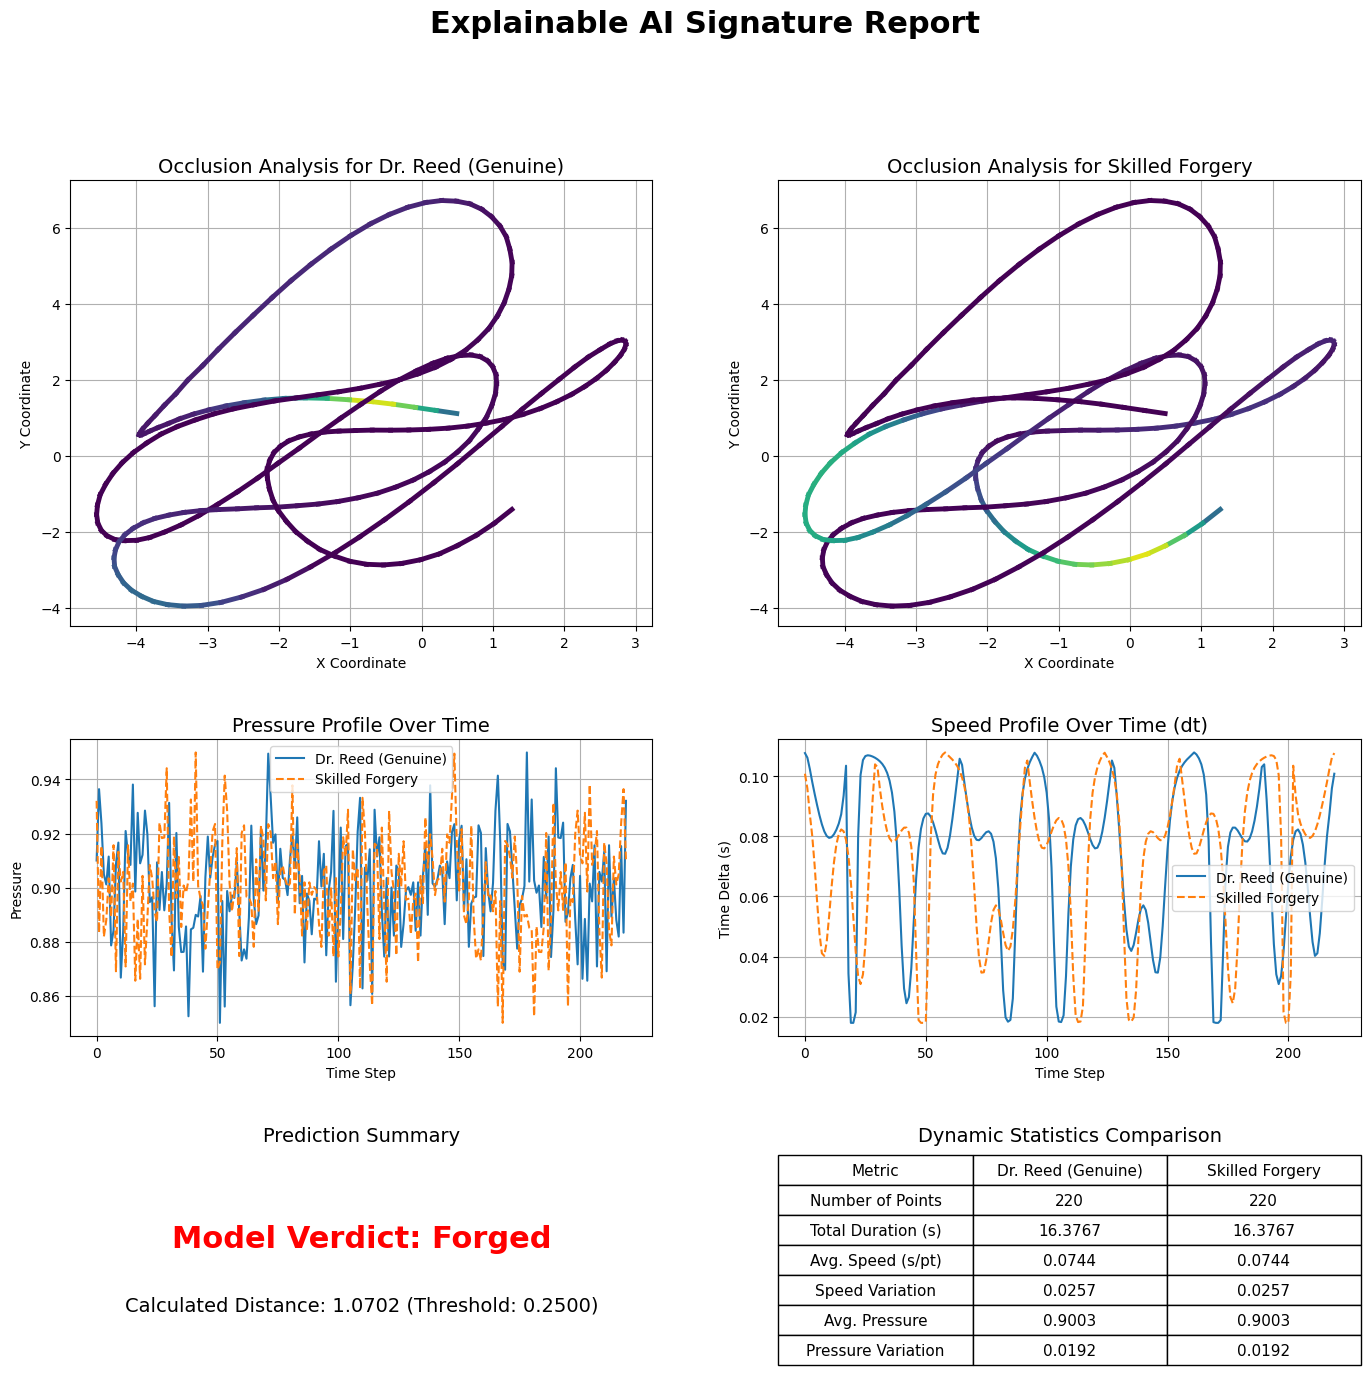

In [21]:
generate_final_enhanced_report(
    sig1=dr_reed_signature,
    sig2=forgery_of_reed,
    sig1_name="Dr. Reed (Genuine)",
    sig2_name="Skilled Forgery",
    base_network=base_network,
    siamese_model=siamese_model,
    max_len=MAX_LEN,
    threshold=THRESHOLD
)

## Report 2: Genuine vs. Different Person


--- Generating Final Enhanced Report: Dr. Reed (Genuine) vs. Mr. Khan (Different) ---


/tmp/ipython-input-3822586118.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis'); norm = mcolors.Normalize(vmin=0, vmax=1.0)


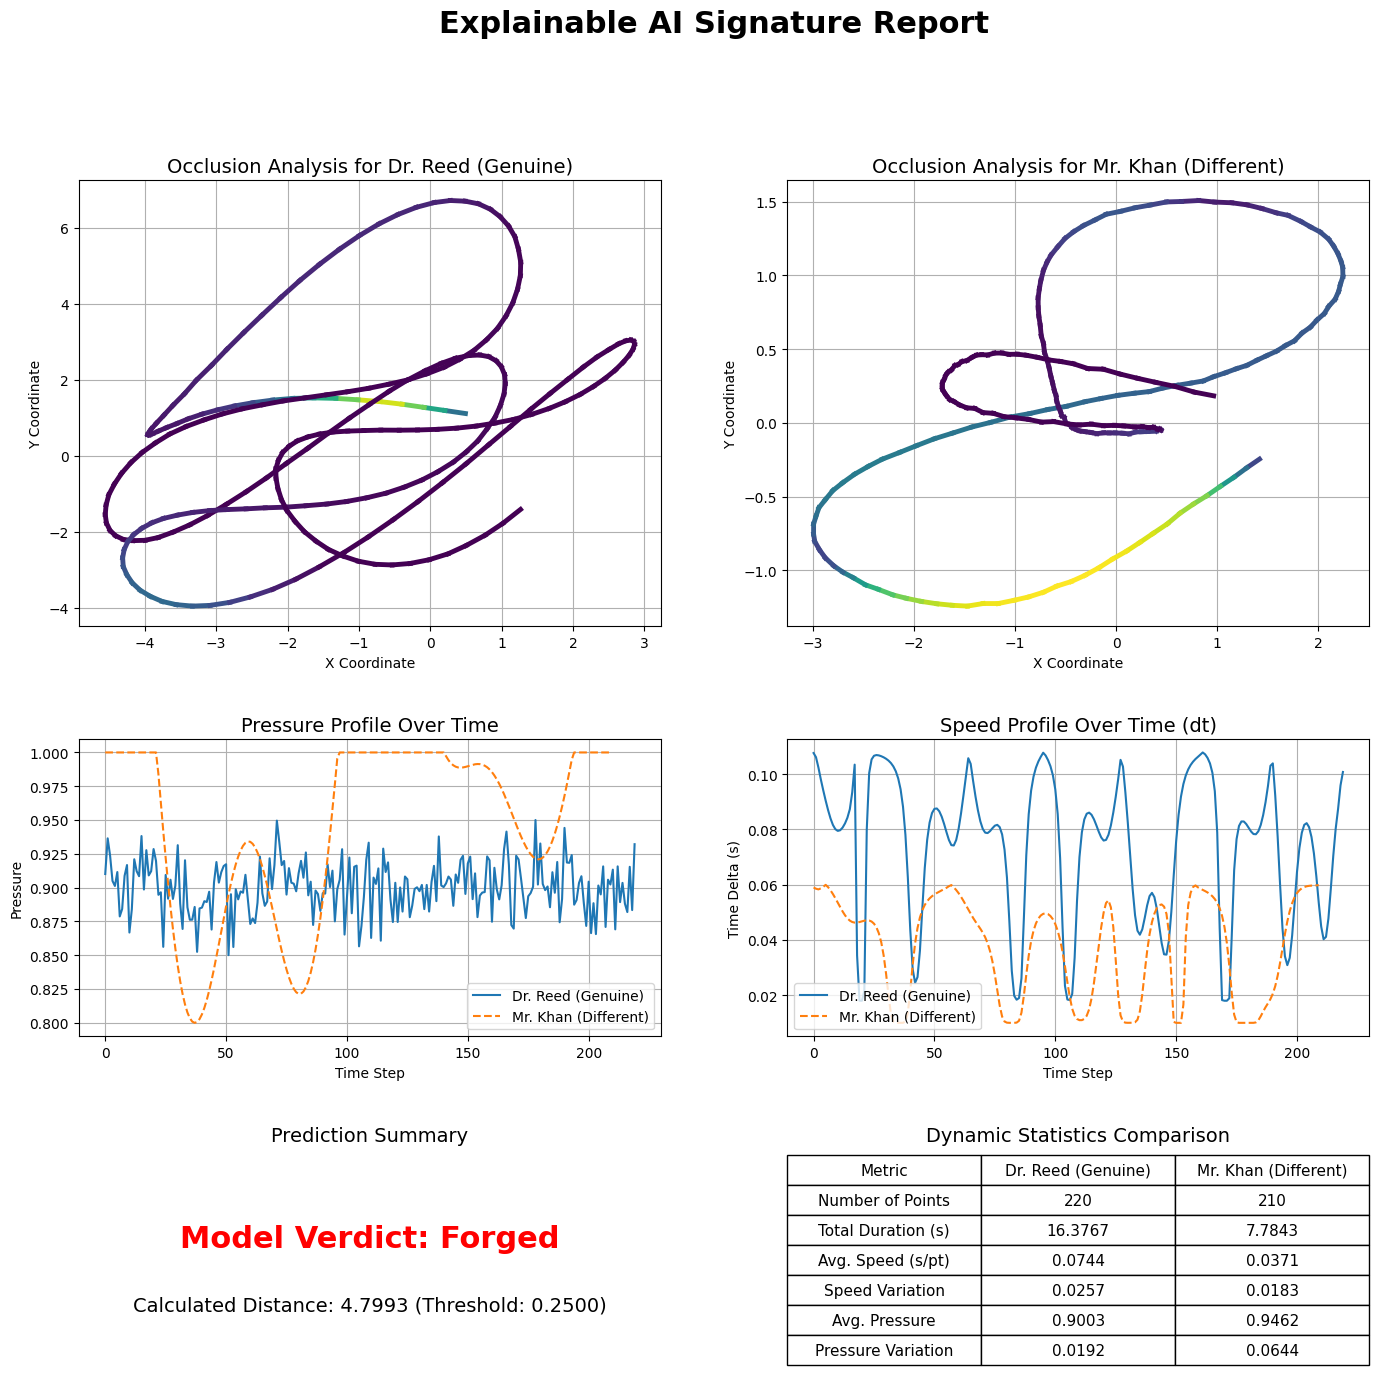

In [18]:
generate_final_enhanced_report(
    sig1=dr_reed_signature,
    sig2=mr_khan_signature,
    sig1_name="Dr. Reed (Genuine)",
    sig2_name="Mr. Khan (Different)",
    base_network=base_network,
    siamese_model=siamese_model,
    max_len=MAX_LEN,
    threshold=THRESHOLD
)

## Report 3: Genuine vs. Genuine Variation


--- Generating Final Enhanced Report: Dr. Reed (Signature 1) vs. Dr. Reed (Signature 2) ---


/tmp/ipython-input-3822586118.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis'); norm = mcolors.Normalize(vmin=0, vmax=1.0)


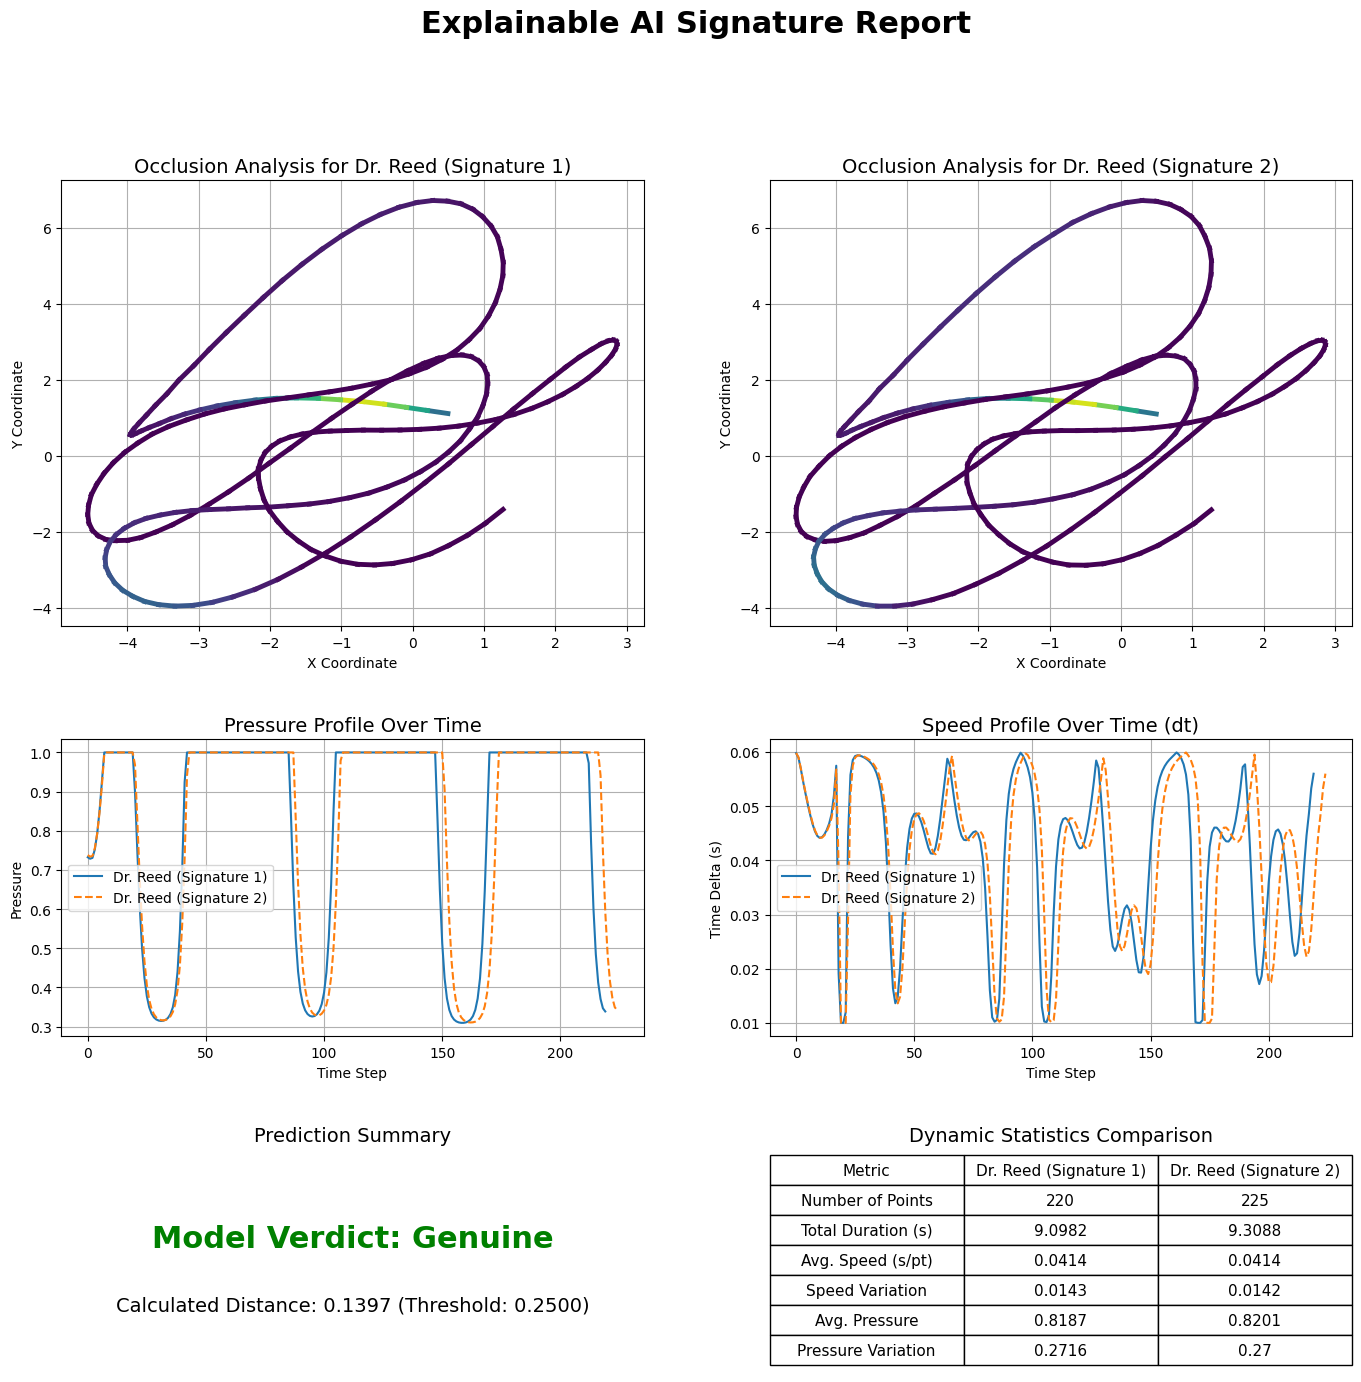

In [20]:
generate_final_enhanced_report(
    sig1=dr_reed_signature_1,
    sig2=dr_reed_signature_2,
    sig1_name="Dr. Reed (Signature 1)",
    sig2_name="Dr. Reed (Signature 2)",
    base_network=base_network,
    siamese_model=siamese_model,
    max_len=MAX_LEN,
    threshold=THRESHOLD
)
